In [94]:
import torch
from transformers import AutoTokenizer
import random
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

MASK_TOKEN_ID = 126336

In [95]:
tokenizer = AutoTokenizer.from_pretrained("GSAI-ML/LLaDA-8B-Instruct", trust_remote_code=True)
vocab_dict = tokenizer.get_vocab()

In [96]:
#dictionary with priority values
rand_dict = {
    (token, token_id): random.random()
    for token, token_id in vocab_dict.items()
}

In [97]:
sampled = list(rand_dict.items())[:5]
for k, v in sampled:
    print(f"{k} → {v:.4f}")

('Ġround', 5949) → 0.6351
('Ġpencils', 70039) → 0.1037
('Ġaccomplishing', 87330) → 0.3469
('ĠAUTH', 28120) → 0.9494
('Ġattained', 55267) → 0.0660


In [98]:
def sampling_schedule(step, total_steps, schedule_type='inv_sigmoid', k=5.0, t=12000):
    """
    Returns the probability of using the scheduled sampling logic (i.e. get_timestamp with uniform mix)
    """
    if schedule_type == 'linear':
        return max(1 - step / total_steps, 0.0)
    elif schedule_type == 'inv_sigmoid':
        sched_prob = k / (k + np.exp(step / t))
        #print(f"Scheduled probability: {sched_prob:.2f}")
        return k / (k + np.exp(step / t))
    else:
        raise ValueError(f"Unknown schedule type: {schedule_type}")

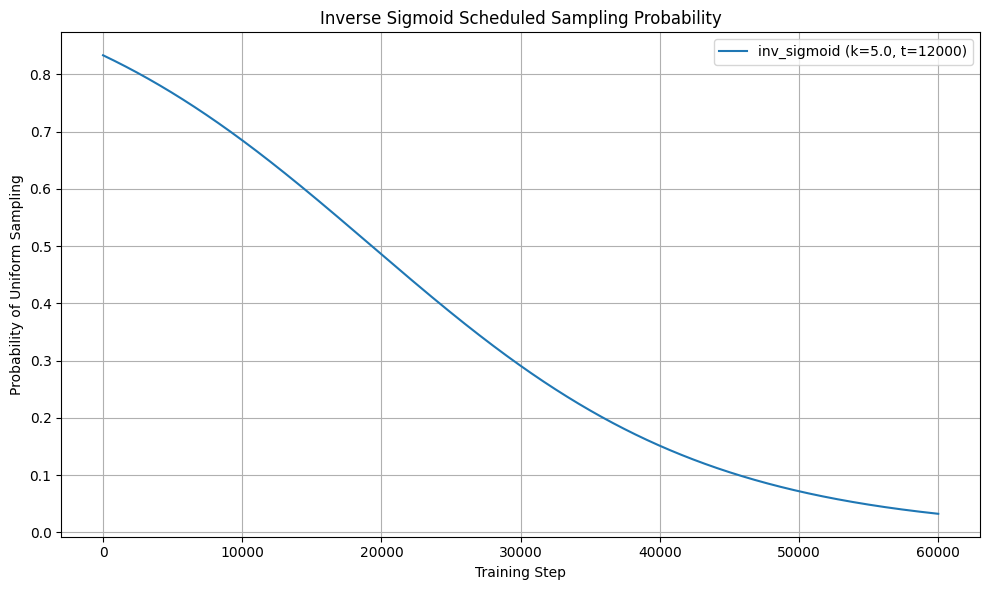

In [99]:
# Settings
total_steps = 60000
k = 5.0
t = 12000

# Generate schedule
steps = np.arange(total_steps)
probs = [sampling_schedule(s, total_steps, 'inv_sigmoid', k=k, t=t) for s in steps]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(steps, probs, label=f'inv_sigmoid (k={k}, t={t})')
plt.title("Inverse Sigmoid Scheduled Sampling Probability")
plt.xlabel("Training Step")
plt.ylabel("Probability of Uniform Sampling")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [100]:
def orig_forward_process(input_ids, mask_prob=0.15, mask_token_id=MASK_TOKEN_ID):
    p_mask = (torch.rand_like(input_ids.float()) < mask_prob)
    noisy_input = input_ids.clone()
    noisy_input[p_mask] = mask_token_id
    return noisy_input, p_mask

def orig_forward_process(input_ids, mask_prob=0.15, mask_token_id=MASK_TOKEN_ID):
    rand = torch.rand_like(input_ids.float())  # shape: (B, L)
    p_mask = rand < mask_prob                 # uniform random masking
    noisy_input = input_ids.clone()
    noisy_input[p_mask] = mask_token_id

    sorted_indices = torch.argsort(rand, dim=1)  # token masking rank, low → high
    return noisy_input, p_mask, sorted_indices

mask_prob → avg actual masked fraction
 0.00     → 0.000
 0.05     → 0.047
 0.10     → 0.095
 0.15     → 0.148
 0.20     → 0.189
 0.25     → 0.257
 0.30     → 0.294
 0.35     → 0.342
 0.40     → 0.394
 0.45     → 0.455
 0.50     → 0.484
 0.55     → 0.561
 0.60     → 0.604
 0.65     → 0.654
 0.70     → 0.693
 0.75     → 0.740
 0.80     → 0.800
 0.85     → 0.847
 0.90     → 0.904
 0.95     → 0.949
 1.00     → 1.000


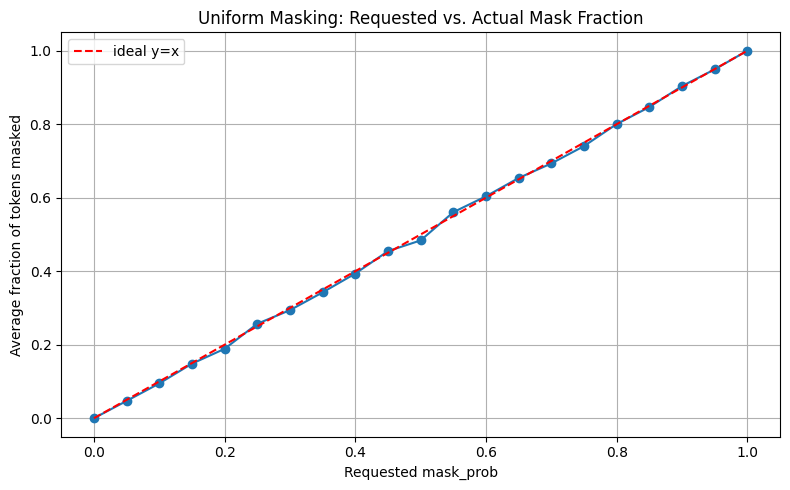

In [101]:
sentence = "The quick brown fox jumped over the lazy dog."
input_ids = tokenizer(sentence, return_tensors="pt").input_ids  # shape (L,)

mask_probs = np.linspace(0.0, 1.0, 21)  # 0.0, 0.05, ..., 1.0
estimates = []

trials = 500

for mp in mask_probs:
    masked_fracs = []
    for _ in range(trials):
        _, p_mask, _ = orig_forward_process(input_ids, mask_prob=mp)
        masked_fracs.append(p_mask.float().mean().item())
    estimates.append(np.mean(masked_fracs))

print("mask_prob → avg actual masked fraction")
for mp, frac in zip(mask_probs, estimates):
    print(f"{mp:5.2f}     → {frac:.3f}")

plt.figure(figsize=(8,5))
plt.plot(mask_probs, estimates, marker='o')
plt.plot([0,1],[0,1], 'r--', label="ideal y=x")
plt.title("Uniform Masking: Requested vs. Actual Mask Fraction")
plt.xlabel("Requested mask_prob")
plt.ylabel("Average fraction of tokens masked")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [104]:
print("\nDecoded masked sequences:")
for mp in [0.1, 0.3, 0.5, 0.8]:
    noisy_ids, p_mask, _ = orig_forward_process(input_ids, mask_prob=mp)
    decoded = tokenizer.decode(noisy_ids.squeeze(0), skip_special_tokens=False)
    print(f"\nmask_prob={mp:.2f}:")
    print(decoded)


Decoded masked sequences:

mask_prob=0.10:
The quick brown<|mdm_mask|> jumped over the lazy dog.

mask_prob=0.30:
The quick brown fox jumped over the lazy<|mdm_mask|>.

mask_prob=0.50:
<|mdm_mask|><|mdm_mask|> brown<|mdm_mask|><|mdm_mask|> over the lazy dog.

mask_prob=0.80:
The<|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|> the<|mdm_mask|> dog<|mdm_mask|>


In [41]:
def build_tokenid_to_priority(vocab_dict, rand_dict, default_priority=0.5):
    max_id = max(vocab_dict.values()) + 1
    table = np.full(max_id, default_priority)
    for (_, token_id), priority in rand_dict.items():
        table[token_id] = priority
    return table

tokenid_to_priority = build_tokenid_to_priority(vocab_dict, rand_dict)

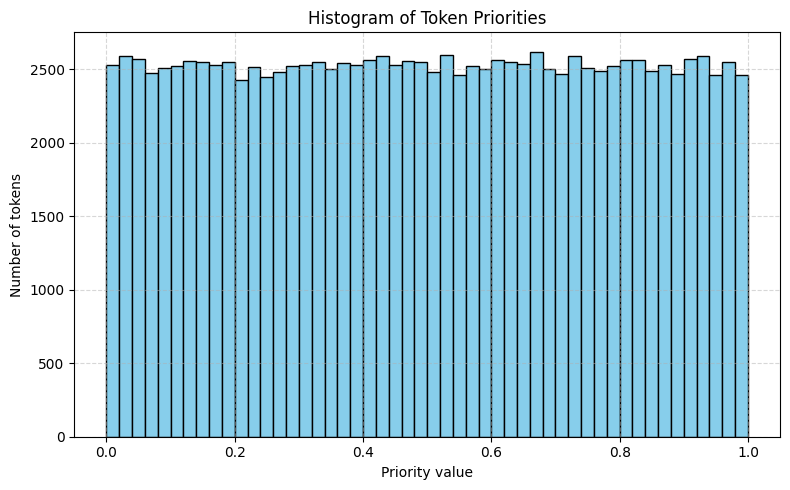

In [105]:
priorities = tokenid_to_priority[: max(vocab_dict.values()) + 1]

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(priorities, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Token Priorities")
plt.xlabel("Priority value")
plt.ylabel("Number of tokens")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [109]:
def new_forward_process(input_ids, mask_prob, tokenid_to_priority,
                        mask_token_id=MASK_TOKEN_ID, temperature=0.4, gamma=4.0):
    device = input_ids.device
    token_ids = input_ids.cpu().numpy()  # (B, L)
    priorities = tokenid_to_priority[token_ids]  # (B, L)

    use_uniform = np.random.rand() < temperature
    k = int(mask_prob * token_ids.shape[1])
    if use_uniform:
        timestamps = np.random.rand(*token_ids.shape)  # shape (B, L)
    else:
        a = 1 + gamma * priorities
        b = 1 + gamma * (1 - priorities)
        timestamps = beta.rvs(a, b, size=token_ids.shape)

    sorted_indices = np.argsort(timestamps, axis=1)  # (B, L)
    B, L = sorted_indices.shape
    row_idx = np.arange(B)[:, None]  # shape (B, 1)
    col_idx = sorted_indices[:, :k]  # shape (B, k)
    
    mask_flags = np.zeros_like(sorted_indices, dtype=bool)
    mask_flags[row_idx, col_idx] = True
        
    p_mask = torch.from_numpy(mask_flags).to(device=input_ids.device)
    noisy_input = input_ids.clone()
    noisy_input[p_mask] = mask_token_id
    return noisy_input, p_mask, sorted_indices

Token priorities:
The          → 0.110
Ġquick       → 0.698
Ġbrown       → 0.017
Ġfox         → 0.759
Ġjumped      → 0.676
Ġover        → 0.824
Ġthe         → 0.790
Ġlazy        → 0.322
Ġdog         → 0.255
.            → 0.460


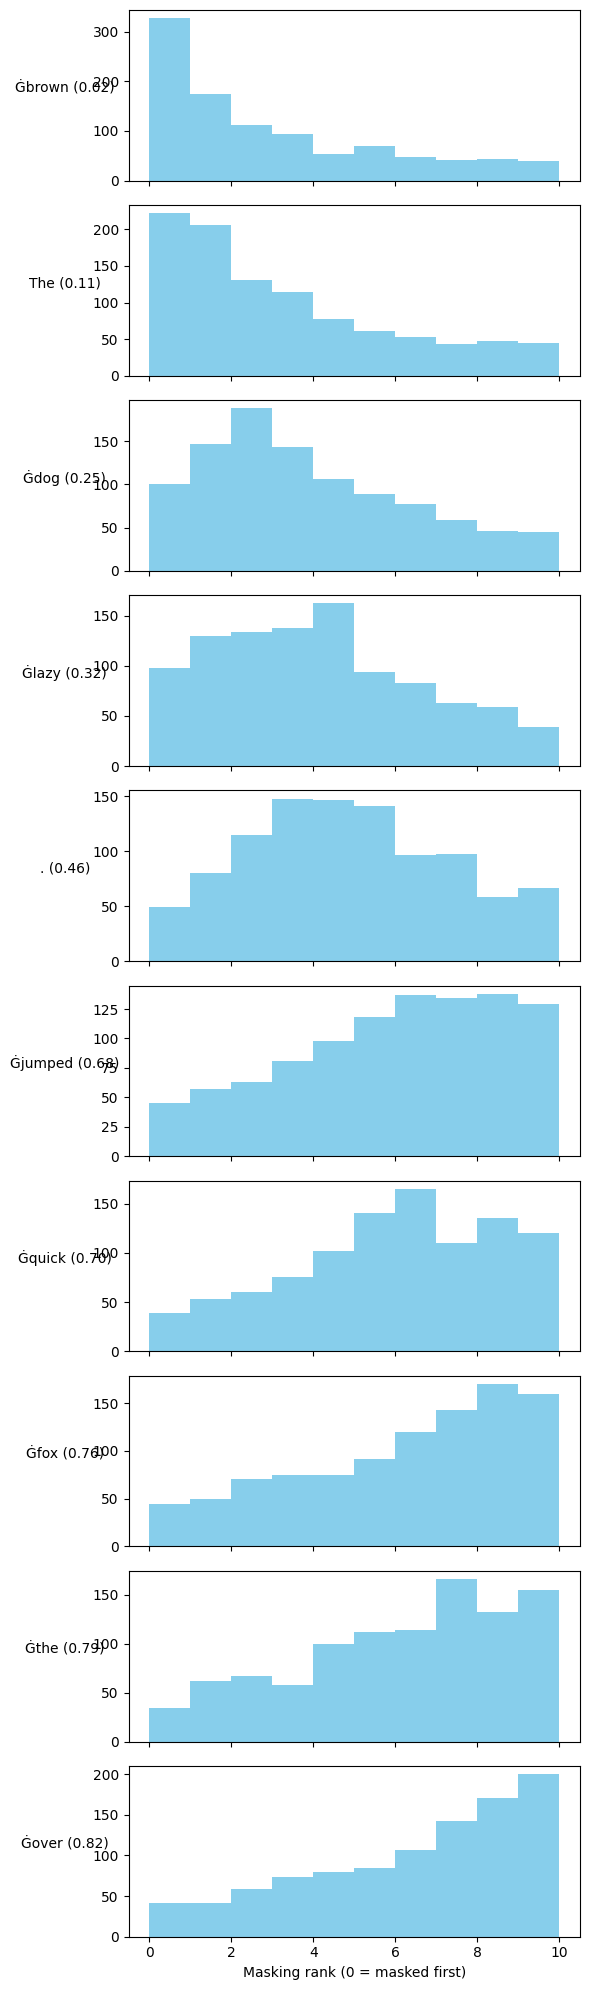


Masked sequences:
mask_prob=0.00: The quick brown fox jumped over the lazy dog.
mask_prob=0.10: The quick brown fox jumped over the lazy<|mdm_mask|>.
mask_prob=0.20: The quick<|mdm_mask|> fox jumped over the lazy<|mdm_mask|>.
mask_prob=0.30: The<|mdm_mask|><|mdm_mask|><|mdm_mask|> jumped over the lazy dog.
mask_prob=0.40: <|mdm_mask|> quick brown fox jumped<|mdm_mask|> the<|mdm_mask|><|mdm_mask|>.
mask_prob=0.50: <|mdm_mask|> quick<|mdm_mask|> fox jumped over<|mdm_mask|><|mdm_mask|><|mdm_mask|>.
mask_prob=0.60: <|mdm_mask|> quick<|mdm_mask|><|mdm_mask|> jumped over<|mdm_mask|><|mdm_mask|><|mdm_mask|>.
mask_prob=0.70: <|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|> over the<|mdm_mask|><|mdm_mask|>.
mask_prob=0.80: <|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|> jumped<|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|>.
mask_prob=0.90: <|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|>.
mask_prob=1.00: <|mdm_mask|><|md

In [110]:
sentence = "The quick brown fox jumped over the lazy dog."
inputs = tokenizer(sentence, return_tensors="pt")
input_ids = inputs.input_ids  # shape: (1, sequence_length)
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

print("Token priorities:")
for tok, tid in zip(tokens, input_ids[0].tolist()):
    print(f"{tok:12s} → {tokenid_to_priority[tid]:.3f}")

mask_prob = 0.5
step = 60000
total_steps = 60000
trials = 1000
ranks = {i: [] for i in range(len(tokens))}

for _ in range(trials):
    noisy_input, p_mask, sorted_indices = new_forward_process(input_ids, mask_prob, tokenid_to_priority, temperature=0.4)
    # sorted_idx[0] records the ranking for the single batch entry
    sorted_idx = np.argsort(sorted_indices[0])
    for pos in range(len(tokens)):
        ranks[pos].append(sorted_idx[pos])

# Get priorities for each token position
token_ids = input_ids[0].tolist()
priorities = [tokenid_to_priority[tid] for tid in token_ids]
sorted_indices = sorted(range(len(tokens)), key=lambda i: priorities[i])

# Plot in sorted priority order
fig, axes = plt.subplots(len(tokens), 1, figsize=(6, 2 * len(tokens)), sharex=True)
for plot_idx, token_idx in enumerate(sorted_indices):
    ax = axes[plot_idx]
    ax.hist(ranks[token_idx], bins=len(tokens), range=(0, len(tokens)), color='skyblue')
    label = f"{tokens[token_idx]} ({priorities[token_idx]:.2f})"
    ax.set_ylabel(label, rotation=0, labelpad=20)
axes[-1].set_xlabel("Masking rank (0 = masked first)")
plt.tight_layout()
plt.show()

def new_forward_and_mask(input_ids, mask_prob,
                         tokenid_to_priority, mask_token_id, temperature, gamma):
    device = input_ids.device
    # Ensure token_ids is 2D (batch size 1, sequence length)
    token_ids = input_ids.cpu().numpy()
    priorities = tokenid_to_priority[token_ids]
    use_uniform = np.random.rand() < temperature
    if use_uniform:
        timestamps = np.random.rand(*token_ids.shape)
    else:
        a = 1 + gamma * priorities
        b = 1 + gamma * (1 - priorities)
        timestamps = beta.rvs(a, b, size=token_ids.shape)
    k = int(mask_prob * token_ids.shape[1])
    sorted_idx = np.argsort(timestamps, axis=1)[0]
    mask = np.zeros_like(token_ids, dtype=bool)
    mask[0, sorted_idx[:k]] = True
    p_mask = torch.from_numpy(mask).to(device=input_ids.device)
    noisy = input_ids.clone()
    noisy[p_mask] = mask_token_id
    return noisy, p_mask

print("\nMasked sequences:")
for mp in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    noisy, _ = new_forward_and_mask(input_ids, mp, 
                                    tokenid_to_priority, MASK_TOKEN_ID, 0.4, 4.0)
    print(f"mask_prob={mp:.2f}: {tokenizer.decode(noisy[0])}")

print("\nAverage masking rank per token:")
for token_idx in sorted_token_indices:
    avg_rank = np.mean(ranks[token_idx])
    print(f"{tokens[token_idx]:12s} → priority={priorities[token_idx]:.3f}, avg_rank={avg_rank:.2f}")


In [111]:
def forward_process(input_ids, mask_prob, step, total_steps, tokenid_to_priority, mask_token_id=MASK_TOKEN_ID, temperature=0.3):
    p = sampling_schedule(step, total_steps)
    if np.random.rand() < p:
        #print("Original Forward Process")
        noisy_input, p_mask, sorted_indices = orig_forward_process(input_ids, mask_prob, mask_token_id=mask_token_id)
    else:
        #print("New Forward Process")
        noisy_input, p_mask, sorted_indices = new_forward_process(input_ids, mask_prob, tokenid_to_priority, mask_token_id=mask_token_id, temperature=temperature)

    return noisy_input, p_mask, sorted_indices

Token priorities:
The          → 0.110
Ġquick       → 0.698
Ġbrown       → 0.017
Ġfox         → 0.759
Ġjumped      → 0.676
Ġover        → 0.824
Ġthe         → 0.790
Ġlazy        → 0.322
Ġdog         → 0.255
.            → 0.460


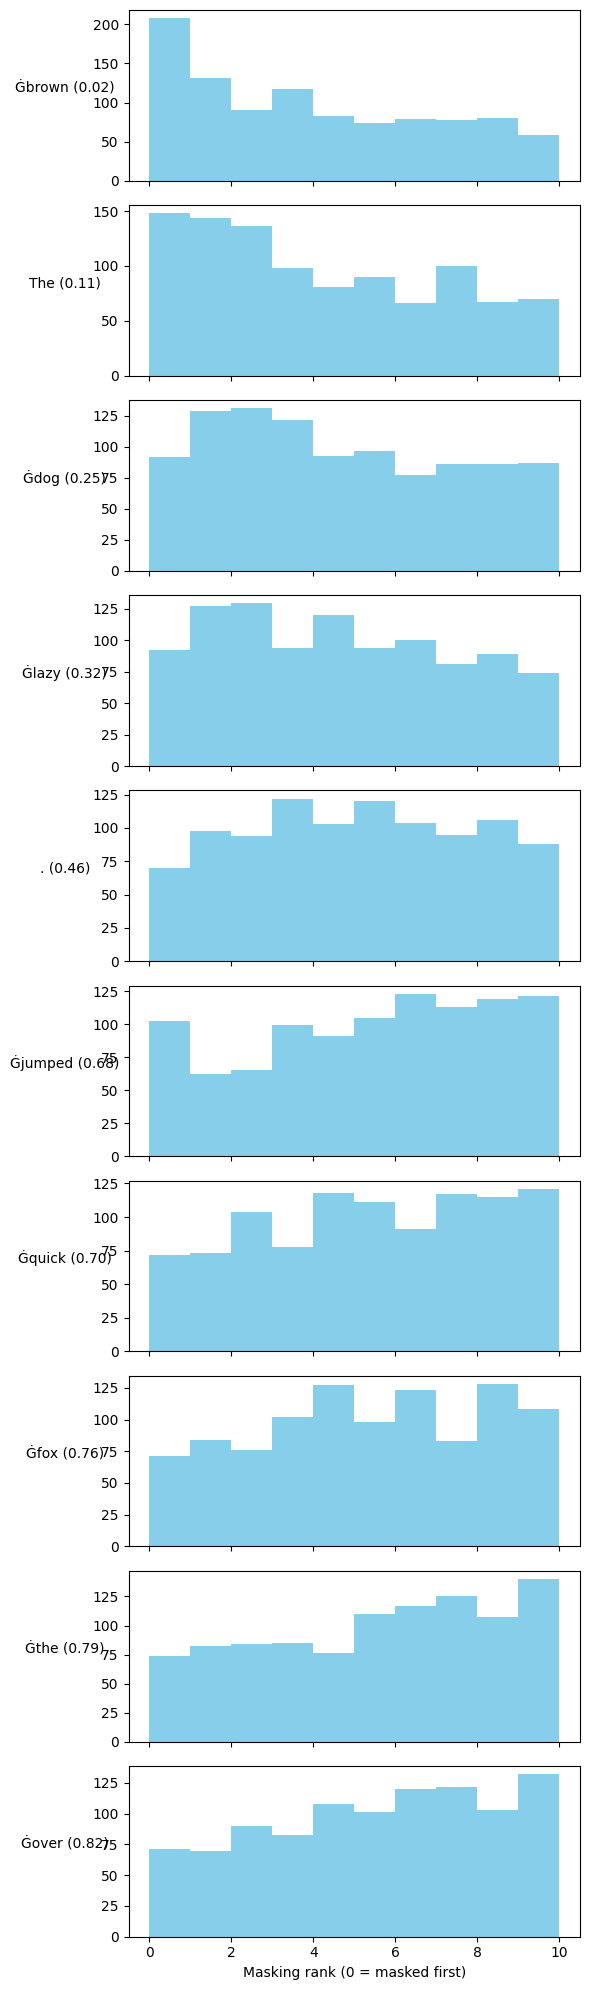


Average masking rank per token:
Ġbrown       → priority=0.017, avg_rank=3.56
The          → priority=0.110, avg_rank=3.75
Ġdog         → priority=0.255, avg_rank=4.15
Ġlazy        → priority=0.322, avg_rank=4.16
.            → priority=0.460, avg_rank=4.59
Ġjumped      → priority=0.676, avg_rank=4.95
Ġquick       → priority=0.698, avg_rank=4.92
Ġfox         → priority=0.759, avg_rank=4.86
Ġthe         → priority=0.790, avg_rank=5.05
Ġover        → priority=0.824, avg_rank=5.02


In [114]:
sentence = "The quick brown fox jumped over the lazy dog."
inputs = tokenizer(sentence, return_tensors="pt")
input_ids = inputs.input_ids  # shape: (1, sequence_length)
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

print("Token priorities:")
token_ids = input_ids[0].tolist()
priorities = [tokenid_to_priority[tid] for tid in token_ids]
for tok, tid in zip(tokens, token_ids):
    print(f"{tok:12s} → {tokenid_to_priority[tid]:.3f}")

# Collect masking ranks
mask_prob = 0.5
step = 10000
total_steps = 60000
trials = 1000
ranks = {i: [] for i in range(len(tokens))}

for _ in range(trials):
    noisy_input, p_mask, sorted_indices = forward_process(
        input_ids, mask_prob, step, total_steps,
        tokenid_to_priority, mask_token_id=MASK_TOKEN_ID, 
        temperature = 0.4
    )
    sorted_idx = np.argsort(sorted_indices[0])
    for pos in range(len(tokens)):
        ranks[pos].append(sorted_idx[pos])

# Sort tokens by priority (ascending)
sorted_token_indices = sorted(range(len(tokens)), key=lambda i: priorities[i])

# Plot per-token histograms
fig, axes = plt.subplots(len(tokens), 1, figsize=(6, 2 * len(tokens)), sharex=True)
for plot_idx, token_idx in enumerate(sorted_token_indices):
    ax = axes[plot_idx]
    ax.hist(ranks[token_idx], bins=len(tokens), range=(0, len(tokens)), color='skyblue')
    label = f"{tokens[token_idx]} ({priorities[token_idx]:.2f})"
    ax.set_ylabel(label, rotation=0, labelpad=20)
axes[-1].set_xlabel("Masking rank (0 = masked first)")
plt.tight_layout()
plt.show()

print("\nAverage masking rank per token:")
for token_idx in sorted_token_indices:
    avg_rank = np.mean(ranks[token_idx])
    print(f"{tokens[token_idx]:12s} → priority={priorities[token_idx]:.3f}, avg_rank={avg_rank:.2f}")
